In [1]:
!pip install emoji

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import nltk
import re
import os
import emoji
import time
from string import punctuation

from pymorphy3 import MorphAnalyzer
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm


from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/Stocks_project/data'

# Import data

In [6]:
news_df = pd.read_csv(os.path.join(data_path,'stock_news.csv'))
news_df.head()

,secid,message_id,channel_db_table,search_string,is_strong,matching_string,message,date_published
0,FEES,245772,messages_markettwits,Россети,0,Россети,**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.06.15\n\n**🇳🇿Н....,2023-06-15 07:25:32.000
1,ROSN,39385,messages_newssmartlab,ROSN,1,\n\n#ROSN,МНЕНИЕ: Дальнейший рост Brent зависит от спрос...,2023-06-05 16:03:18.000
2,HYDR,245832,messages_markettwits,РусГидро,0,"* ""РусГидро""*","🇷🇺#HYDR \n** ""РусГидро""** ведет с энергопотреб...",2023-06-15 10:27:47.000
3,SBER,245850,messages_markettwits,SBER,1,🇺#SBER\n*,🇷🇺#SBER\n**Сбербанк **абсолютно конкурентен в ...,2023-06-15 11:27:15.000
4,SBER,245850,messages_markettwits,Сбербанк,0,*Сбербанк *,🇷🇺#SBER\n**Сбербанк **абсолютно конкурентен в ...,2023-06-15 11:27:15.000


In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284041 entries, 0 to 284040
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   secid             284041 non-null  object
 1   message_id        284041 non-null  int64 
 2   channel_db_table  284041 non-null  object
 3   search_string     284041 non-null  object
 4   is_strong         284041 non-null  int64 
 5   matching_string   284041 non-null  object
 6   message           284041 non-null  object
 7   date_published    284041 non-null  object
dtypes: int64(2), object(6)
memory usage: 17.3+ MB


In [8]:
orig_size = news_df.shape[0]
f'Количество строк в сырых данных:{orig_size}'

'Количество строк в сырых данных:284041'

In [9]:
f'Количество явных дубликатов: {news_df.duplicated().sum()}'

'Количество явных дубликатов: 2'

In [10]:
news_df = news_df.drop_duplicates()

In [11]:
is_unique = news_df['message_id'].is_unique
print("Уникальные ли значения в столбце message_id:", is_unique)

Уникальные ли значения в столбце message_id: False


In [12]:
f'Количество тикеров: {news_df.secid.nunique()}'

'Количество тикеров: 189'

Таблица с алиасами

In [13]:
aliases = pd.read_csv(os.path.join(data_path,'stock_search_aliases.csv'))
aliases.head()

,secid,search_string,is_strong
0,ABIO,ARTGEN,0
1,ABIO,ABIO,1
2,ABIO,АРТГЕН,0
3,ABIO,ISKJ,1
4,ABRD,Абрау-Дюрсо,0


In [14]:
sorted(aliases[aliases['is_strong'] == 1]['search_string'].tolist())

['ABIO',
 'ABRD',
 'ACKO',
 'AFKS',
 'AFLT',
 'AKRN',
 'ALRS',
 'AMEZ',
 'APTK',
 'AQUA',
 'ARSA',
 'ASSB',
 'ASTR',
 'AVAN',
 'BANE',
 'BELU',
 'BLNG',
 'BRZL',
 'BSPB',
 'CARM',
 'CBOM',
 'CHGZ',
 'CHKZ',
 'CHMF',
 'CHMK',
 'CNTL',
 'DELI',
 'DIAS',
 'DIOD',
 'DVEC',
 'DZRD',
 'EELT',
 'ELFV',
 'ENPG',
 'ENRU',
 'EUTR',
 'FEES',
 'FESH',
 'FLOT',
 'GAZC',
 'GAZP',
 'GAZS',
 'GAZT',
 'GCHE',
 'GECO',
 'GEMA',
 'GEMC',
 'GMKN',
 'GTRK',
 'HNFG',
 'HYDR',
 'IGST',
 'INGR',
 'IRAO',
 'IRKT',
 'ISKJ',
 'JNOS',
 'KAZT',
 'KBSB',
 'KCHE',
 'KGKC',
 'KLSB',
 'KLVZ',
 'KMAZ',
 'KMEZ',
 'KOGK',
 'KRKN',
 'KROT',
 'KRSB',
 'KUBE',
 'KUZB',
 'KZOS',
 'LEAS',
 'LENT',
 'LKOH',
 'LNZL',
 'LSNG',
 'LSRG',
 'LVHK',
 'MAGE',
 'MAGN',
 'MAIL',
 'MFGS',
 'MGKL',
 'MGNT',
 'MGNZ',
 'MGTS',
 'MISB',
 'MOEX',
 'MRKC',
 'MRKK',
 'MRKP',
 'MRKS',
 'MRKU',
 'MRKV',
 'MRKY',
 'MRKZ',
 'MRSB',
 'MSNG',
 'MSRS',
 'MSTT',
 'MTLR',
 'MTSS',
 'MVID',
 'NAUK',
 'NFAZ',
 'NKHP',
 'NKNC',
 'NKSH',
 'NLMK',
 'NMTP',
 

In [15]:
sorted(aliases[aliases['is_strong'] == 0]['search_string'].tolist())

[' Якутская топл.-энерг. ',
 'AFK Sistema',
 'ALROSA',
 'ARTGEN',
 'ASKO',
 'AVANGARD',
 'Abrau-Durso',
 'Acron',
 'Aeroflot',
 'Apteki 36,6',
 'Arsagera',
 'Ashinckiy',
 'Astra',
 'Astrakhan Energo Sbyt',
 'BSP',
 'Bank "Kuzneckiy"',
 'Bashneft',
 'Belon',
 'Buryatzoloto',
 'CKPZ',
 'CMK',
 'CMT',
 'CZPSN-Profnasteel',
 'Carsharing Russia',
 'Cherkizovo',
 'DEC',
 'DVMP',
 'Diasoft',
 'EN+',
 'El5-Ener',
 'Eltech',
 'Europlan',
 'EvroTrans',
 'GAZ-Tek',
 'GENETICO',
 'GTM',
 'Gaz-servis',
 'Gazkon',
 'Gazprom',
 'Gazprom gazorasp. Rostov ao',
 'Gazprom neft',
 'Globaltruck',
 'HENDERSON',
 'IMCB',
 'INARCTIKA',
 'INGRAD',
 'Inter RAO',
 'Izhstal',
 'KAMAZ',
 'KRISTALL',
 'Kalugsk. Sbyt',
 'Kamchatskenergo',
 'Korshunovskii GOK',
 'Kovrov Mech',
 'Krashojarskenergosbyt',
 'KrasnyiOctyabr',
 'Kuib.Azot',
 'KuibAzot',
 'Kurganskaja Gener',
 'LSR',
 'LUKOIL',
 'Lenta',
 'Lenzoloto',
 'Levenguk',
 'M.video',
 'MKB',
 'MMK',
 'MTS',
 'MVideo',
 'Magadanenergo',
 'Magnit',
 'Mailru',
 'Meche

# Delete duplicates

Кол-во дубликатов новостей, которые привязались по тикерам и по названиям компаний. Проверяем по каналам в том числе, поскольку message_id уникальны только в рамках одного канала:

In [16]:
news_df[(
    (news_df['is_strong'] == 0) &
    (news_df.duplicated(subset=['message_id', 'secid', 'channel_db_table'], keep=False))
)].shape[0]

82556

Оставляем только те новости, которые привязались по тикерам, потому что это более сильные связи.

In [17]:
no_duplicates  = news_df[~(
    (news_df['is_strong'] == 0) &
    (news_df.duplicated(subset=['message_id', 'secid', 'channel_db_table'], keep=False))
)]

In [18]:
no_duplicates.shape

(201483, 8)

In [19]:
news_df.shape[0] - no_duplicates.shape[0]

82556

In [20]:
no_duplicates[(
    (no_duplicates['is_strong'] == 1) &
    (no_duplicates.duplicated(subset=['message_id', 'secid', 'channel_db_table'], keep=False))
)]['matching_string'].tolist()

[' #ABIO \n',
 '🇺#ISKJ #',
 ' #MAIL #',
 '\n\n#VKCO #',
 ' #ABIO\n\n*',
 ' #ISKJ ',
 ' #MAIL #',
 '#VKCO #',
 ' #VKCO\n*',
 ' #VKCO\n*',
 '  #MAIL #',
 ' #VKCO\n\n⛏',
 ' (ABIO):',
 ' (ISKJ)~',
 '~ #ABIO\n*',
 '~#ISKJ~',
 ' ISKJ ',
 ' ABIO\n🇷',
 '" ISKJ ',
 ' (ISKJ)~',
 ' MAIL ',
 ' VKCO.',
 ' MAIL ',
 ' VKCO\n\n🇺',
 '\n\n#MAIL',
 '📉VKCO (*',
 ': MAIL-',
 ' VKCO ',
 ' ABIO.',
 ' ISKJ ',
 '🇺#MAIL #',
 ' #MAIL',
 '#MAIL #',
 '#MAIL #',
 ' (ABIO):',
 ' ABIO\n\n',
 ' ABIO\n\n',
 ' ISKJ ',
 '*MAIL-',
 ' VKCO(',
 ' #MAIL\n',
 '🇺#VKCO #',
 '🇺#MAIL #',
 ' #VKCO #',
 '🇺#MAIL #',
 ' #VKCO\n',
 ' #MAIL #',
 ' #VKCO \n"',
 ' #VKCO #',
 '🇺#MAIL #',
 ' #VKCO ',
 '💥#VKCO #',
 ' #MAIL',
 ' #VKCO #',
 ' #MAIL\n',
 '🇺#VKCO #',
 ' #MAIL',
 '💥#VKCO #',
 ' #MAIL #',
 ')#VKCO #']

Удаляем дубликаты новостей, которые имеют общий канал-источник, id и тикер. Они задублировались за счет привязки по тикеру, который был у компании ранее. (Мы уже удаляли такие дубликаты, которые привязались по синонимам, но со слабой связью). Оставляем только 1 экземпляр.

In [21]:
# Удаляем дубликаты, оставляя только первый экземпляр
no_duplicates = no_duplicates.drop_duplicates(subset=['message_id', 'secid', 'channel_db_table'], keep='first')
no_duplicates.shape[0]

201453

In [22]:
f'Кол-во новостей, привязанных по слабым связям: {no_duplicates[no_duplicates["is_strong"] == 0].shape[0]}'

'Кол-во новостей, привязанных по слабым связям: 48966'

Посмотрим на список алиасов со слабыми связями в нашем датасете

In [23]:
weak_str_lst = no_duplicates[no_duplicates['is_strong']==0]['search_string'].tolist()
counter = Counter(weak_str_lst)
sorted_counts = counter.most_common()
sorted_counts

[('Тинькофф', 3249),
 ('ВТБ', 3240),
 ('РБК', 2911),
 ('Россети', 1912),
 ('Яндекс', 1782),
 ('Сбербанк', 1672),
 ('МТС', 1485),
 ('Роснефть', 1089),
 ('Татнефть', 989),
 ('Сургутнефтегаз', 986),
 ('СПБ Биржа', 872),
 ('Магнит', 828),
 ('Ренессанс', 810),
 ('VK', 806),
 ('ММК', 782),
 ('НЛМК', 763),
 ('Новатэк', 719),
 ('Северсталь', 716),
 ('Полюс', 715),
 ('Ростелеком', 657),
 ('Аэрофлот', 627),
 ('Самолет', 606),
 ('Мечел', 602),
 ('ПИК', 559),
 ('Башнефть', 502),
 ('Лента', 481),
 ('Совкомбанк', 476),
 ('TCS', 463),
 ('Сегежа', 427),
 ('Softline', 419),
 ('ФосАгро', 417),
 ('Positive', 412),
 ('АФК Система', 406),
 ('Polymetal', 390),
 ('Юнипро', 388),
 ('Совкомфлот', 384),
 ('Полиметалл', 377),
 ('АЛРОСА', 357),
 ('Интер РАО', 356),
 ('ЛСР', 349),
 ('Позитив', 343),
 ('ТМК', 327),
 ('Ленэнерго', 325),
 ('Газпром нефть', 306),
 ('РусГидро', 304),
 ('Россети Центр', 303),
 ('Астра', 293),
 ('Селигдар', 286),
 ('МКБ', 271),
 ('ЛУКОЙЛ', 268),
 ('Tinkoff', 266),
 ('Черкизово', 258),
 (

# Clean RegExp annotation

Оставляем только сильную связь (по тикеру) для РБК, Тинькофф, ВТБ, Сбербанк, МТС, Яндекс, Лента из-за омонимии с упоминаниями этих компаний как источников информации. Большинство случаев будут покрыты тэгом тикера.

In [24]:
pattern_rbk = 'РБК'
no_duplicates[no_duplicates['message'].str.contains(pattern_rbk, regex=True)]['message'].tolist()[:5]

['🪙 **Через 15 минут на ПМЭФ-2023 обсудят перспективы индустрии майнинга криптовалют.\n\n**Отдельная панельная дискуссия под названием «Майнинг как «белый лебедь» российской экономики: что нужно делать уже сейчас?» пройдет 15 июня с 17:00 до 18:00 с участием представителей государственных ведомств, банков, бизнеса и СМИ. Участники обсудят перспективы майнинга биткоина в контексте инвестиционной привлекательности, прогресс создания законодательной базы для оборота криптовалют в России, а также вопрос потребления электроэнергии промышленными майнерами и использования ее альтернативных источников.\n\nМесто проведения: КВЦ Экспофорум, Конгресс-центр, Конференц-зал D3. Смотрите тансляцию на главной странице сайта РБК www.rbc.ru',
 '🇺🇦#cash #цифровизация #украина \nБанковская система Украины технически готова к\xa0полному **отказу от\xa0наличных** расчетов, заявила первый заместитель главы Нацбанка Екатерина Рожкова — РБК',
 '🇷🇺#отчетности #россия \nВыручка российских компаний впервые превыс

In [25]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='RBCM'))]

In [26]:
pattern_tinkoff = 'Тинькофф|Tinkoff'
no_duplicates[no_duplicates['message'].str.contains(pattern_tinkoff, regex=True)]['message'].tolist()[:5]

['🇷🇺#блокировка #акции #россия \nУправляющая компания «Тинькофф Капитал» [сообщила](https://quote.ru/news/article/64905fe69a79472e0117181e) о начале выделения **заблокированных** иностранных ценных бумаг в отдельные закрытые паевые инвестиционные фонды (ЗПИФ).',
 '❗️🇷🇺#акции #россия \n В Тинькофф Инвестициях все клиенты с плечами получили уведомления о маржин-коллах\n\nмногие связывают пролив в акциях РФ именно с этим',
 '🇷🇺#дивиденды #акции #россия \nКлиенты «Тинькофф» [реинвестировали](https://quote.rbc.ru/news/article/6492dcaf9a79478b431aeeec) **дивиденды** ЛУКОЙЛа в **российские акции.** Ранее такая же ситуация была с дивидендами «Сбера», который стал наиболее популярной бумагой для реинвестирования полученных выплат',
 '🇷🇺🇮🇳#fx #банки #россия \n«Тинькофф» [запустил](https://www.kommersant.ru/doc/6055631) международные переводы в **рупиях**',
 '🇷🇺#SBER \n**Сбер** обостряет борьбу с СБП - банк ведет переговоры с крупными банками о подключении к сервису «Плати QR». На сегодняшний ден

In [27]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='TCSG'))]

In [28]:
pattern_vtb = 'ВТБ'
no_duplicates[no_duplicates['message'].str.contains(pattern_vtb, regex=True)]['message'].tolist()[:5]

['🇷🇺#it #техи #россия \nТехнологический суверенитет в сфере** IT** является одним из приоритетов развития в перспективе ближайших лет[ — ВТБ](https://www.kommersant.ru/doc/6044282)',
 '❗️🇷🇺#YNDX #VTBR\n**ВТБ **НЕ БУДЕТ УЧАСТВОВАТЬ В СДЕЛКЕ ПО ПОКУПКЕ ДОЛИ В** "ЯНДЕКСЕ"** - КОСТИН — ИФ',
 '🇷🇺#VTBR \n**ВТБ **пока окончательно не определился с планами продажи "Росгосстраха" - Костин — ИФ',
 '🇷🇺#VTBR #дивиденд \n**ВТБ **может вернуться к выплате дивидендов "еще через один период" [— Костин \n\n](https://1prime.ru/banks/20230616/840846275.html)выплату дивидендов за 2023 год глава ВТБ назвал проблематичной',
 '✴️🇷🇺#цфа #крипто #россия \nВТБ и РЖД [провели ](https://tass.ru/ekonomika/18033077)крупнейшую в России сделку с **ЦФА. **Объем выпуска достиг 15 млрд рублей\n\nВ роли эмитента крупнейшей сделки с цифровым финансовым активом в России выступило ОАО "Российские железные дороги", в роли инвестора - ВТБ Факторинг (ГК). Объем выпуска составил 15 млрд рублей. Срок обращения ЦФА - 180 дней. Ст

In [29]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='VTBR'))]

In [30]:
pattern_sberbank = 'Sberbank|Сбербанк'
no_duplicates[no_duplicates['message'].str.contains(pattern_sberbank, regex=True)]['message'].tolist()[:5]

['🇷🇺#SBER\n**Сбербанк **абсолютно конкурентен в финансовом секторе - Греф',
 '⚡️🇷🇺#SBER\nв **Сбере **[сообщили](https://www.gazeta.ru/business/news/2023/06/15/20671004.shtml) о возможности переводов в 11 стран\n\nКлиенты Сбербанка могут переводить деньги в 11 стран, сообщил первый заместитель председателя правления Сбера Кирилл Царёв на полях ПМЭФ-2023',
 '🇷🇺#SBER\n**Сбербанк** полностью вышел с европейского рынка, продал австрийскую "дочку"  — ИФ\n\nСбербанк [закрыл](https://www.vedomosti.ru/business/news/2023/06/16/980835-sberbank-zakril-sdelku-prodazhe-dochki-avstrii) сделку по продаже «дочки» в Австрии',
 '🇷🇺#SBER \n**Сбербанк** с 1 июля проиндексирует зарплату сотрудникам на 10% — Греф — РИА',
 '💥🇷🇺#SBER #отчетность #прогноз \n**Сбербанк **ждет "нормальный" финансовый результат в 2023г, поэтому повысит зарплату сотрудникам - Греф — ИФ']

In [31]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='SBER'))]

In [32]:
pattern_yandex = 'Яндекс|Yandex'
no_duplicates[no_duplicates['message'].str.contains(pattern_yandex, regex=True)]['message'].tolist()[:5]

['МНЕНИЕ: Яндекс и VK имеют выгодное положение среди разработчиков приложений - Газпромбанк\n\nЧитать далее\n👉 https://smartlab.news/i/13752\n\n#YNDX #MAIL',
 '🇷🇺#YNDX \n**«Яндекс.Маркет» **открывает аукцион. Маркетплейс апробирует новый инструмент для поставщиков. Это позволит сократить издержки и снизить зависимость по некоторым категориям от независимых продавцов. [— Ъ](https://www.kommersant.ru/doc/6043963)',
 '#Идея\n**🧠 Закрытые идеи Мозгового центра Сигналов РЦБ\n\n**🟢 Прибыль\n— ДВМП ([+41.5%](https://t.me/cbrstocks/50999), [+31%](https://t.me/cbrstocks/40553))\n— [ЕвропЭлтех](https://t.me/cbrstocks/46231) +40%\n— [Мать и дитя ](https://t.me/cbrstocks/49882)+34.5%\n— [Эталон](https://t.me/cbrstocks/47763) +25%\n— [Совкомфлот](https://t.me/cbrstocks/56802) +23%\n— [Магнит ](https://t.me/cbrstocks/50612)+20.3%\n— Сургутнефтегаз ао ([+20.0%](https://t.me/cbrstocks/54648) [+2.4%](https://t.me/cbrstocks/56695))\n— Бонды [М.Видео](https://t.me/cbrstocks/54604) 4 выпуск +19.84%\n— [По

In [33]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='YNDX'))]

In [34]:
pattern_mts = 'МТС|MTS'
no_duplicates[no_duplicates['message'].str.contains(pattern_mts, regex=True)]['message'].tolist()[:5]

['⚠️🇷🇺#MTSS #суд\n**МТС** проиграл разбирательство против Туркменистана по делу об остановке бизнеса в стране — Law360',
 '**🔦 МТС (**[MTSS](https://neo.putinomics.com/dashboard/mtss/moex)**): справедливая стоимость 407.9 руб, апсайд +30%.\n**👉 https://neo.putinomics.com/dashboard/mtss/moex\n\n#оценка #MTSS \n@AK47pfl',
 '**Атон (о МТС): **\n\nКомпания сохраняет устойчивые показатели основного бизнеса в условиях непростой экономической ситуации, что обеспечивает ей сильный операционный денежный поток. Важно, что МТС поддерживает на высоком уровне базу абонентов, в то время как у некоторых ее публичных конкурентов наблюдается отток клиентов.\n\nисточник: [aton.ru](https://www.aton.ru/upload/research/DividendsExtended.pdf)',
 '**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.06.27\n\n**🇹🇷Турция - короткий торговый день \n🇪🇺выступление главы ЕЦБ Лагард - 11:00мск\n🇺🇸США - Durable Goods Orders (май) - 15:30мск\n🇨🇦Канада - потребинфляция CPI (май) - 15:30мск\n🇺🇸США - SP-Case-Schiller Index (апр) - 16:00мск\n

In [35]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='MTSS'))]

In [36]:
pattern_lenta= r'(Lenta|Лента)\.(ru|ру)'
no_duplicates[((no_duplicates.message.str.contains(pattern_lenta, regex=True)) & (no_duplicates.secid == 'LENT'))]

,secid,message_id,channel_db_table,search_string,is_strong,matching_string,message,date_published
57621,LENT,15146,messages_AK47pfl,Лента,0,• Лента.,⭐️ **Топовые российские СМИ цитируют РДВ:\n\n•...,2023-05-26 17:00:00.000
59588,LENT,15776,messages_AK47pfl,Лента,0,• Лента.,**⭐️ Топовые российские СМИ цитируют РДВ:\n\n•...,2023-08-29 13:01:24.000
89435,LENT,4999,messages_brokervtb,Лента,0,🔹[Лента.,"#ВоскресноеЧтение \n\n💙 Сегодня воскресенье, а...",2023-11-19 13:30:44.000
225178,LENT,37804,messages_karaulny_accountant,Lenta,0,Lenta.,[​​](https://telegra.ph/file/00251b00d5ba46d1a...,2021-06-23 10:18:21.000


In [37]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='LENT'))]

In [38]:
pattern_samolet= r'Самолет'
no_duplicates[(no_duplicates.matching_string.str.contains(pattern_samolet, regex=True))]

,secid,message_id,channel_db_table,search_string,is_strong,matching_string,message,date_published
752,SMLT,248877,messages_markettwits,Самолет,0,\nСамолет,🇷🇺#UNAC \nСамолет Ту-214 будет полностью дораб...,2023-07-10 14:30:55.000
1050,SMLT,30498,messages_headlines_for_traders,Самолет,0,. Самолет\n,**SberCIB (топ акций средней и малой капитализ...,2023-06-06 10:02:28.000
1125,SMLT,56921,messages_cbrstocks,Самолет,0,— [Самолет](,#Идея\n**🧠 Закрытые идеи Мозгового центра Сигн...,2023-12-27 13:16:41.000
2482,SMLT,56931,messages_cbrstocks,Самолет,0,) [Самолет](,"#Идея\nОк, проверяем\n\n**С осени 2022 года Мо...",2023-12-27 17:47:09.000
2925,SMLT,30639,messages_headlines_for_traders,Самолет,0,. Самолет\n,**ВТБ (топ акций на рынке РФ):\n\n**1. Whoosh\...,2023-06-13 11:45:00.000
...,...,...,...,...,...,...,...,...
276929,SMLT,203271,messages_markettwits,Самолет,0,"\nСамолет,",⚠️🇺🇸🇹🇼🇨🇳#тайвань #китай #сша #геополитика\nСам...,2022-08-02 14:19:58.000
277106,SMLT,10137,messages_AK47pfl,Самолет,0,. Самолет,**Топ-25 компаний по росту выручки.** Рост выр...,2021-10-22 19:30:09.000
280158,SMLT,56803,messages_cbrstocks,Самолет,0,— [Самолет](,#Идея\n**🧠 Закрытые идеи Мозгового центра Сигн...,2023-12-22 14:13:24.000
281449,SMLT,232110,messages_markettwits,Самолет,0,"Самолет,",🇷🇺#торги #россия #инструменты \nс 9 марта** Мо...,2023-03-06 15:52:32.000


Убираем также новости,которые привязались по алиасу Cамолет, из-за омонимии.

In [39]:
no_duplicates = no_duplicates[~(
    (no_duplicates['is_strong'] == 0) &
    (no_duplicates['secid']=='SMLT'))]

Удаляем также строки, которые привязались по слабой связи ГАЗПРОМ, когда речь идет о ГАЗПРОМ НЕФТИ.  

In [40]:
pattern_gazprom = r'ГАЗПРОМ|Gazprom'
no_duplicates[((no_duplicates['message'].str.contains(r'SIBN')) &
                (no_duplicates['matching_string'].str.contains(pattern_gazprom, regex=True)) &
                                (no_duplicates['secid'] == 'GAZP'))]

,secid,message_id,channel_db_table,search_string,is_strong,matching_string,message,date_published
422,GAZP,247843,messages_markettwits,ГАЗПРОМ,0,"*""ГАЗПРОМ","💥🇷🇺#SIBN #дивиденд\n**""ГАЗПРОМ НЕФТЬ"" **ВЫПЛАТ...",2023-06-30 18:01:28.000
1479,GAZP,253012,messages_markettwits,ГАЗПРОМ,0,* ГАЗПРОМ,🇷🇺#SIBN #отчетность\nЧИСТАЯ ПРИБЫЛЬ** ГАЗПРОМ ...,2023-08-10 19:01:35.000
1758,GAZP,254539,messages_markettwits,ГАЗПРОМ,0,*ГАЗПРОМ,🇷🇺#SIBN #отчетность \nПРИБЫЛЬ **ГАЗПРОМ НЕФТИ ...,2023-08-24 09:30:40.000
2320,GAZP,257953,messages_markettwits,ГАЗПРОМ,0,\nГАЗПРОМ,"💥🇷🇺#SIBN\nГАЗПРОМ НЕФТЬ, СКОРЕЕ ВСЕГО, ВЫПЛАТИ...",2023-09-20 12:00:50.000
2321,GAZP,257954,messages_markettwits,ГАЗПРОМ,0,\nГАЗПРОМ,🇷🇺#SIBN\nГАЗПРОМ НЕФТЬ НЕ ПЛАНИРУЕТ ОФЕРТУ НЕР...,2023-09-20 12:01:26.000
...,...,...,...,...,...,...,...,...
273142,GAZP,175874,messages_markettwits,ГАЗПРОМ,0,"\n""ГАЗПРОМ","⚡️🇷🇺#SIBN\n""ГАЗПРОМ НЕФТЬ"" ПЛАНИРУЕТ В 2023 И ...",2022-01-26 11:44:30.000
273631,GAZP,179216,messages_markettwits,ГАЗПРОМ,0,"\n""ГАЗПРОМ","🇷🇺#SIBN #дивиденд \n""ГАЗПРОМ НЕФТЬ"" БУДЕТ ПРИД...",2022-02-17 18:21:28.000
277566,GAZP,206860,messages_markettwits,ГАЗПРОМ,0,"* ""ГАЗПРОМ","⚡️🛢🇷🇺#SIBN\n** ""ГАЗПРОМ НЕФТЬ""** ЗАПУСТИЛА НОВ...",2022-08-30 15:01:07.000
281572,GAZP,235050,messages_markettwits,ГАЗПРОМ,0,"""ГАЗПРОМ",⚠️🛢🇷🇺#нефтегаз #россия #прогноз #санкции\n2023...,2023-03-28 11:37:28.000


In [41]:
no_duplicates = no_duplicates[~((no_duplicates['message'].str.contains(r'SIBN')) &
                (no_duplicates['matching_string'].str.contains(pattern_gazprom, regex=True)) &
                                (no_duplicates['secid'] == 'GAZP'))]

Удаляем ложные срабатывания для Россети

In [42]:
aliases[aliases.search_string.str.contains(r'Россети')]

,secid,search_string,is_strong
137,FEES,Россети,0
261,KUBE,Россети Кубань,0
330,MRKC,Россети Центр,0
332,MRKK,Россети СК,0
335,MRKP,Россети Центр и Приволжье,0
341,MRKS,Россети Сибирь,0
348,MRKV,Россети Волга,0
350,MRKY,Россети Юг,0
357,MRKZ,Россети Северо-Запад,0
368,MSRS,Россети Московский регион,0


In [43]:
secid_rosseti = aliases[aliases.search_string.str.contains(r'Россети')]['secid'].tolist()
secid_rosseti.remove('FEES')
secid_rosseti

['KUBE', 'MRKC', 'MRKK', 'MRKP', 'MRKS', 'MRKV', 'MRKY', 'MRKZ', 'MSRS']

In [44]:
pattern_rosseti_homonyms = r'KUBE|MRKC|MRKK|MRKP|MRKS|MRKV|MRKY|MRKZ|MSRS'
pattern_rosseti_misc = r'Россети\s*(Кубань|Центр|СК|Сибирь|Волга|Юг|Северо-Запад|Московский)'

no_duplicates[
    (no_duplicates['matching_string'].str.contains('Россети', regex=True)) &
     (no_duplicates['message'].str.contains(pattern_rosseti_homonyms, regex=True)) &
     (no_duplicates['message'].str.contains(pattern_rosseti_misc, regex=True)) &
    (no_duplicates['secid']=='FEES')
]

,secid,message_id,channel_db_table,search_string,is_strong,matching_string,message,date_published
0,FEES,245772,messages_markettwits,Россети,0,Россети,**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.06.15\n\n**🇳🇿Н....,2023-06-15 07:25:32.000
20,FEES,245895,messages_markettwits,Россети,0,"* ""Россети","⚠️🇷🇺#MRKZ #дивиденд \nакционеры** ""Россети Сев...",2023-06-15 15:25:05.000
86,FEES,246032,messages_markettwits,Россети,0,Россети,**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.06.16\n\n**🇯🇵Яп...,2023-06-16 07:28:10.000
265,FEES,246684,messages_markettwits,Россети,0,"* ""Россети","💥🇷🇺#MSRS #дивиденд\nакционеры** ""Россети Моско...",2023-06-21 14:06:17.000
564,FEES,247919,messages_markettwits,Россети,0,"""Россети",**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.07.03\n\n**🇺🇸СШ...,2023-07-03 07:28:40.000
...,...,...,...,...,...,...,...,...
281740,FEES,234093,messages_markettwits,Россети,0,"*""Россети","🇷🇺#KUBE\nПАО **""Россети Кубань"" **-[ приостано...",2023-03-21 16:56:29.000
281844,FEES,234596,messages_markettwits,Россети,0,«Россети,🇷🇺#MRKS #отчетность \nУбыток группы ПАО** «Рос...,2023-03-24 08:05:59.000
282958,FEES,241079,messages_markettwits,Россети,0,Россети,**🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.05.11\n\n**🇨🇳КН...,2023-05-11 07:26:14.000
283090,FEES,241661,messages_markettwits,Россети,0,* Россети,⚠️🇷🇺#MRKS #дивиденд \nсд** Россети Сибирь:** д...,2023-05-16 08:03:46.000


In [45]:
no_duplicates = no_duplicates[~(
    (no_duplicates['matching_string'].str.contains('Россети', regex=True)) &
     (no_duplicates['message'].str.contains(pattern_rosseti_homonyms, regex=True)) &
     (no_duplicates['message'].str.contains(pattern_rosseti_misc, regex=True)) &
    (no_duplicates['secid']=='FEES')
    )
]
no_duplicates.shape[0]

183960

In [46]:
pattern = r'/[A-Z]{4}'

counter = Counter(no_duplicates[
    (no_duplicates['is_strong'] == 1) &
    (no_duplicates['matching_string'].str.match(pattern))
]['matching_string'].tolist())

sorted_counts = counter.most_common()
sorted_counts[:10]

[('/MOEX)*', 1271),
 ('/MOEX)) ', 1193),
 ('/MOEX?', 703),
 ('/MOEX)):', 153),
 ('/MOEX)),', 120),
 ('/MOEX))', 74),
 ('/MOEX) ', 73),
 ('/MOEX)) [', 48),
 ('/MOEX)).', 47),
 ('/SBER/', 31)]

In [47]:
pattern_moex = r'/MOEX'
no_duplicates[no_duplicates['matching_string'].str.match(pattern_moex)]['message'].tolist()[:5]

['#SBER\n🏦 Сбер ([SBER](https://putinomics.ru/dashboard/sber/MOEX)): 2021 год оказался лучше ожиданий для российской экономики — Греф.\n\nЭто способствовало росту банковских рынков. Ипотека стала ключевым драйвером.',
 '#LKOH\n🛢 ЛУКОЙЛ ([LKOH](https://putinomics.ru/dashboard/LKOH/MOEX)) ПОДАЛ В ГОСОРГАНЫ РУМЫНИИ ЗАЯВКУ НА ДАЛЬНЕЙШУЮ ОЦЕНКУ РЕСУРСОВ ПРОЕКТА НА ШЕЛЬФЕ',
 '#NVTK\n⛽️ НОВАТЭК ([NVTK](https://putinomics.ru/dashboard/nvtk/MOEX)) ВЕДЕТ ПЕРЕГОВОРЫ С ПОКУПАТЕЛЯМИ В АЗИИ ПО НОВЫМ КОНТРАКТАМ НА ПОСТАВКУ СПГ, ИЗ ЕВРОПЫ ДАЖЕ ПРИ ТЕКУЩИХ ЦЕНАХ НА ГАЗ ОБРАЩЕНИЙ НЕТ - МИХЕЛЬСОН',
 '#NVTK\n⛽️ НОВАТЭК ([NVTK](https://putinomics.ru/dashboard/nvtk/MOEX)) БУДЕТ УЛАВЛИВАТЬ И ЗАХОРАНИВАТЬ 5 МЛН Т СО2 В РАМКАХ ОБСКОГО ГХК, ЧАСТИЧНО С ЯМАЛ СПГ',
 '#NLMK #Отчетность\n🖨 [Подробная отчетность НЛМК](https://nlmk.com/upload/iblock/ee9/NLMK_Financial_Release-_-Q3-2021_RUS.pdf) ([NLMK](https://neo.putinomics.ru/dashboard/nlmk/MOEX)) по МСФО за 3 квартал']

In [48]:
f'Кол-во сообщений со ссылками на Мосбиржу, которые привязались к тикеру MOEX: ' \
                 f'{len(no_duplicates[no_duplicates["matching_string"].str.match(pattern_moex)])}'

'Кол-во сообщений со ссылками на Мосбиржу, которые привязались к тикеру MOEX: 3936'

Удаляем строки с подстрокой поиска /MOEX - это ссылки на сайт биржи в большинстве случаев.

In [49]:
no_duplicates= no_duplicates[~no_duplicates['matching_string'].str.match(pattern_moex)]
no_duplicates.shape[0]

180024

# Make the final dataset

In [50]:
final_df = (
    no_duplicates.assign(value=1)
    .pivot_table(
        index=["message_id", "channel_db_table", "date_published", "message"],
        columns="secid",
        values="value",
        fill_value=0
    )
    .reset_index()
)
final_df.head()

secid,message_id,channel_db_table,date_published,message,ABIO,ABRD,ACKO,AFKS,AFLT,AKRN,...,VTBR,WTCM,WUSH,YAKG,YKEN,YNDX,YRSB,ZAYM,ZILL,ZVEZ
0,4,messages_newssmartlab,2021-03-29 14:49:55.000,Прибыль Татнефть 20 г РСБУ снизилась почти в 2...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,messages_alexpolyarniy,2022-12-26 18:21:17.000,**Важные события текущей недели на фондовых ры...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,messages_newssmartlab,2021-03-29 15:31:02.000,Менеджмент ЛСР будет постепенно повышать дивид...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,messages_cozybasis,2024-01-03 20:16:08.000,🧩 **Такая вот статистика у нашего рынка по сек...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,messages_st_trade,2023-10-27 12:48:37.000,$KAZT классно подошел к ЕМА 20 на недельном гр...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
f'Размер финального датасета: {final_df.shape[0]} строк'

'Размер финального датасета: 134742 строк'

In [52]:
final_df.isna().sum()

,0
secid,
message_id,0
channel_db_table,0
date_published,0
message,0
ABIO,0
...,...
YNDX,0
YRSB,0
ZAYM,0


In [53]:
final_df.duplicated().sum()

0

In [54]:
tickers = [col for col in final_df.columns if col != "message_id" and col != "channel_db_table" and col != "date_published" and col != "message"]
f'Количество тикеров: {len(tickers)}'

'Количество тикеров: 189'

In [55]:
final_df[tickers] = final_df[tickers].astype('uint8')
final_df['date_published'] = pd.to_datetime(final_df['date_published'], errors='coerce')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134742 entries, 0 to 134741
Columns: 193 entries, message_id to ZVEZ
dtypes: datetime64[ns](1), int64(1), object(2), uint8(189)
memory usage: 28.4+ MB


In [56]:
final_df.head()

secid,message_id,channel_db_table,date_published,message,ABIO,ABRD,ACKO,AFKS,AFLT,AKRN,...,VTBR,WTCM,WUSH,YAKG,YKEN,YNDX,YRSB,ZAYM,ZILL,ZVEZ
0,4,messages_newssmartlab,2021-03-29 14:49:55,Прибыль Татнефть 20 г РСБУ снизилась почти в 2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,messages_alexpolyarniy,2022-12-26 18:21:17,**Важные события текущей недели на фондовых ры...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,messages_newssmartlab,2021-03-29 15:31:02,Менеджмент ЛСР будет постепенно повышать дивид...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,messages_cozybasis,2024-01-03 20:16:08,🧩 **Такая вот статистика у нашего рынка по сек...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,messages_st_trade,2023-10-27 12:48:37,$KAZT классно подошел к ЕМА 20 на недельном гр...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Подсчет количества слов в каждой новости

In [57]:
final_df["num_words"] = final_df["message"].apply(
    lambda x: len(str(x).split()))

In [58]:
final_df[(final_df.num_words ==final_df.num_words.min())]['message']

,message
975,YNDX
2517,AQUA
2536,**SBER**
2680,**BELU**
2771,**KMAZ**
...,...
124002,💥🇷🇺#ROSN
124150,💥🇷🇺#AFLT
125679,🇷🇺#LSNG
128808,🇷🇺#SGZH


Удаляем строки с небольшим кол-вом слов (меньше или равно 5). Это в основном подписи к картинкам и часто там используется сам тэг тикера.

In [59]:
indexes_to_drop = final_df[final_df.num_words <=5].index
print('Кол-во строк с минимальным кол-вом слов:', len(indexes_to_drop))
# Удаляем строки по найденным индексам
final_df.drop(index=indexes_to_drop, inplace=True)
final_df.reset_index(drop=True, inplace=True)

Кол-во строк с минимальным кол-вом слов: 1885


In [60]:
min_date = final_df['date_published'].min()
max_date = final_df['date_published'].max()

min_date_str = min_date.strftime('%d %B %Y')
max_date_str = max_date.strftime('%d %B %Y')

print(f"Период данных, охватывающий новости: c {min_date_str} по {max_date_str}")

Период данных, охватывающий новости: c 02 January 2021 по 12 June 2024


# News Distribution by TG Channels

In [61]:
fig = px.histogram(
    final_df,
    x="channel_db_table",
    title=f"News Distribution by Telegram Channels from {min_date_str} to {max_date_str}",
    labels={"Channel name": "Name", "count": "Number of News"},
    template="plotly_white"
)

fig.update_xaxes(
    title="Telegram Channels",
    tickangle=45,
    tickfont=dict(size=10),
    automargin=True
)


fig.update_yaxes(
    title="Number of News",
    tickformat=","
)

fig.update_layout(
    width=1400,
    height=600,
    bargap=0.1,
)

fig.write_html(os.path.join(data_path, "news_distribution_by_tg_channels.html"))
print("График сохранён в файл 'news_distribution_by_tg_channels'. Откройте его в браузере!")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Target (Tickers) Distribution

In [62]:
class_sums = final_df[tickers].sum()

fig = px.bar(
    x=class_sums.index,
    y=class_sums.values,
    title=f"News Distribution by Tickers from {min_date_str} to {max_date_str}",
    labels={"x": "Ticker", "y": "Number of News"},
    template="plotly_white"
)


fig.update_xaxes(
    title="Tickers",
    tickangle=45,
    tickfont=dict(size=10),
    automargin=True
)


fig.update_yaxes(
    title="Number of News",
    tickformat=","  # Отображение чисел без K/M
)


fig.update_layout(
    width=1400,
    height=600,
    bargap=0.1,
)


fig.write_html(os.path.join(data_path,"news_distribution_by_tickers.html"))


print("График сохранён в файл 'news_distribution_by_tickers.html'. Откройте его в браузере!")
fig.show()

График сохранён в файл 'news_distribution_by_tickers.html'. Откройте его в браузере!


In [63]:
absolute_counts = final_df[tickers].sum()
total_news = len(final_df)
percentage_counts = (absolute_counts / total_news) * 100
result = pd.DataFrame({
    'Ticker': tickers,
    'Absolute Count': absolute_counts.values,
    'Percentage': percentage_counts.values
})

result = result.sort_values(by='Absolute Count', ascending=False)
pd.set_option('display.max_rows', None)
result

,Ticker,Absolute Count,Percentage
39,GAZP,8938,6.727534
139,SBER,5069,3.815380
129,ROSN,4732,3.561724
36,FESH,4413,3.321616
85,MOEX,4358,3.280219
184,YNDX,4285,3.225272
110,NVTK,3881,2.921186
72,LKOH,3792,2.854197
3,AFKS,3729,2.806777
4,AFLT,3722,2.801508


In [64]:
pd.reset_option('display.max_rows')

Есть совсем малочисленные классы. Редкие классы имеют слишком мало данных для корректного обучения модели. Поэтому мы на данный момент удалим такие классы. В данном случае назначим порог, ниже которого классы считаются редкими, равным 1.5% от общего числа объектов.

In [65]:
# Определение порога
low_represented_threshold = 0.015  # Порог для редких классов (1.5%)

# Вычисление доли каждого класса
class_means = final_df[tickers].mean()

# Определение редких классов
low_represented_classes = class_means[class_means < low_represented_threshold].index

# Удаление редких классов из данных
data_filtered = final_df.drop(columns=low_represented_classes)

# Обновляем список классов для предсказания
tickers_high_rep = [ticker for ticker in tickers if ticker not in low_represented_classes]
f'Кол-во тикеров в отфильтрованном датасете: {len(tickers_high_rep)}'

# Удаление строк без меток тикеров
data_filtered = data_filtered[data_filtered[tickers_high_rep].sum(axis=1) > 0]

print('Количество строк в датасете до удаления редких классов:', final_df.shape[0])
print('Количество строк в датасете после удаления редких классов:', data_filtered.shape[0])
print('Кол-во тикеров в отфильтрованном датасете:', len(tickers_high_rep))

Количество строк в датасете до удаления редких классов: 132857
Количество строк в датасете после удаления редких классов: 91737
Кол-во тикеров в отфильтрованном датасете: 36


In [66]:
class_sums = data_filtered[tickers_high_rep].sum()

fig = px.bar(
    x=class_sums.index,
    y=class_sums.values,
    title=f"News Distribution by Tickers from {min_date_str} to {max_date_str}",
    labels={"x": "Ticker", "y": "Number of News"},
    template="plotly_white"
)


fig.update_xaxes(
    title="Tickers",
    tickangle=45,
    tickfont=dict(size=10),
    automargin=True
)


fig.update_yaxes(
    title="Number of News",
    tickformat=","  # Отображение чисел без K/M
)


fig.update_layout(
    width=1400,
    height=600,
    bargap=0.1,
)


fig.write_html(os.path.join(data_path,"news_distribution_by_36tickers.html"))


print("График сохранён в файл 'news_distribution_by_36tickers.html'. Откройте его в браузере!")
fig.show()

График сохранён в файл 'news_distribution_by_36tickers.html'. Откройте его в браузере!


# News Distribution by Datetime

In [67]:
final_df['year'] = final_df['date_published'].dt.year
final_df['month'] = final_df['date_published'].dt.strftime("%B")
final_df['weekday'] = final_df['date_published'].dt.strftime('%A')

data_filtered['year'] = data_filtered['date_published'].dt.year
data_filtered['month'] = data_filtered['date_published'].dt.strftime("%B")
data_filtered['weekday'] = data_filtered['date_published'].dt.strftime('%A')

In [68]:
fig = make_subplots(rows=3, cols=1, subplot_titles=["By Year", "By Month", "By Weekday"])

columns = ["year", "month", "weekday"]
for ind, col in enumerate(columns):
    value_counts = final_df[col].value_counts(ascending=True)
    unique_values = value_counts.index.astype(str)

    colors = px.colors.qualitative.Plotly  # Выбираем палитру (можно поменять)
    color_mapping = {val: colors[i % len(colors)] for i, val in enumerate(unique_values)}

    fig.add_trace(
        go.Bar(
            x=unique_values,
            y=value_counts.values,
            marker=dict(color=[color_mapping[val] for val in unique_values]),  # Присваиваем цвета
            name=col
        ),
        row=ind + 1,
        col=1
    )

fig.update_layout(
    height=800,
    width=1000,
    title_text="Number of News by Datetime",
    title_x=0.5,
    showlegend=False  # Отключаем легенду, чтобы не нагружать график
)

fig.update_xaxes(type="category")

fig.update_yaxes(
    title="Number of News",
    tickformat=","
)

fig.write_html(os.path.join(data_path,"news_distribution_by_datetime.html"))
print("График сохранён в файл 'news_distribution_by_datetime.html'. Откройте его в браузере!")
fig.show()

График сохранён в файл 'news_distribution_by_datetime.html'. Откройте его в браузере!


In [69]:
fig = make_subplots(rows=3, cols=1, subplot_titles=["By Year", "By Month", "By Weekday"])

columns = ["year", "month", "weekday"]
for ind, col in enumerate(columns):
    value_counts = data_filtered[col].value_counts(ascending=True)
    unique_values = value_counts.index.astype(str)

    colors = px.colors.qualitative.Plotly  # Выбираем палитру (можно поменять)
    color_mapping = {val: colors[i % len(colors)] for i, val in enumerate(unique_values)}

    fig.add_trace(
        go.Bar(
            x=unique_values,
            y=value_counts.values,
            marker=dict(color=[color_mapping[val] for val in unique_values]),  # Присваиваем цвета
            name=col
        ),
        row=ind + 1,
        col=1
    )

fig.update_layout(
    height=800,
    width=1000,
    title_text="Number of News by Datetime",
    title_x=0.5,
    showlegend=False  # Отключаем легенду, чтобы не нагружать график
)

fig.update_xaxes(type="category")

fig.update_yaxes(
    title="Number of News",
    tickformat=","
)

fig.write_html(os.path.join(data_path,"news_distribution_by_datetime_tickers_highRep.html"))
print("График сохранён в файл 'news_distribution_by_datetime_tickers_highRep.html'. Откройте его в браузере!")
fig.show()

График сохранён в файл 'news_distribution_by_datetime_tickers_highRep.html'. Откройте его в браузере!


# Word Cloud

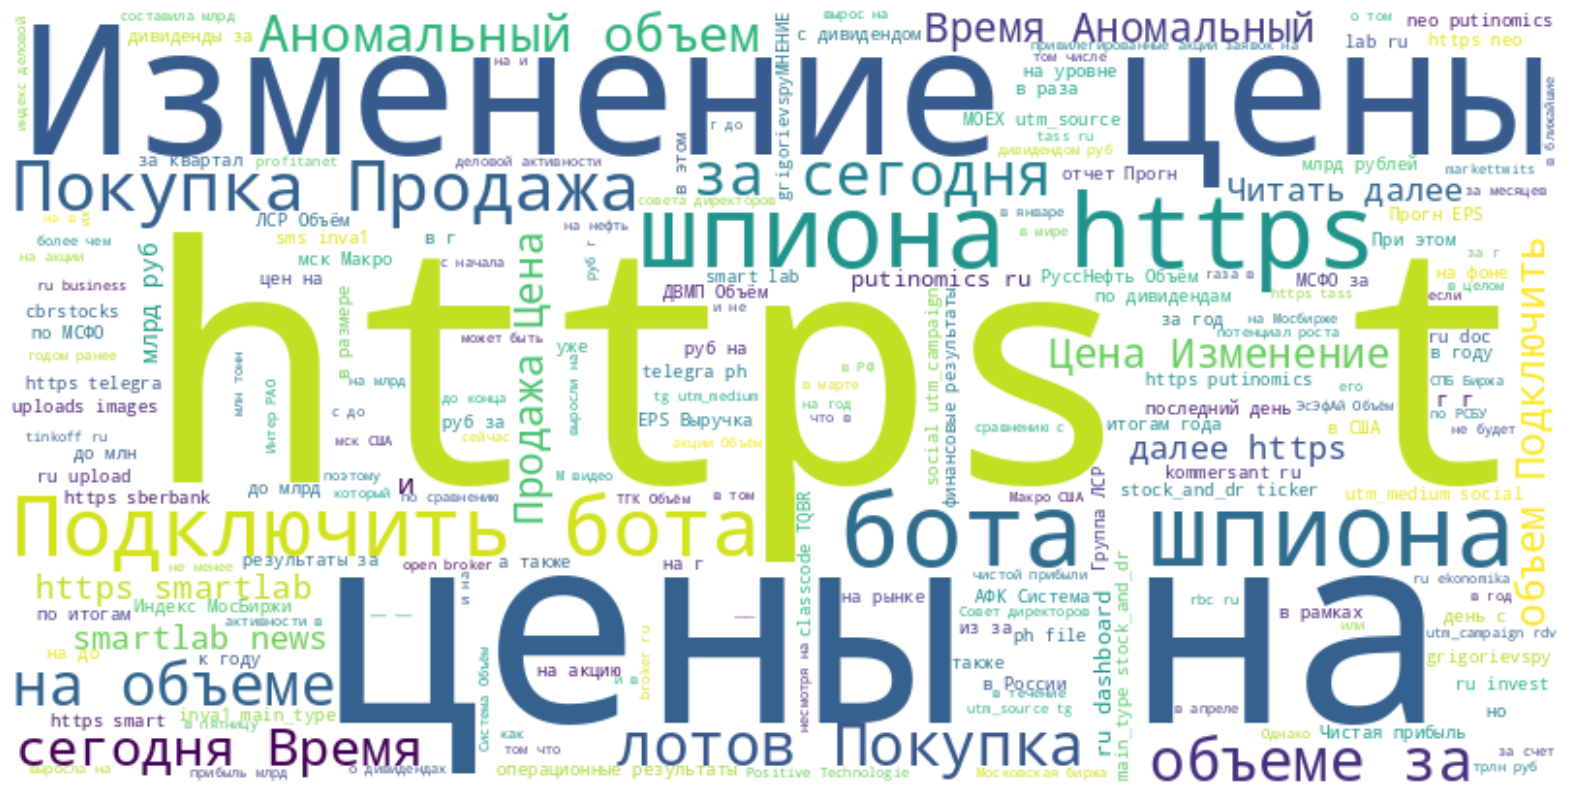

In [70]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    "".join(map(str, final_df.message)))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [72]:
final_df.drop(columns=['num_words', 'year', 'month', 'weekday'], inplace=True)
data_filtered.drop(columns=['num_words', 'year', 'month', 'weekday'], inplace=True)
final_df.rename(columns={'message': 'text'}, inplace=True)
data_filtered.rename(columns={'message': 'text'}, inplace=True)

In [73]:
final_df.to_csv(os.path.join(data_path, 'final_news.csv'), index=False)
data_filtered.to_csv(os.path.join(data_path, 'news_high_rep_tickers.csv'), index=False)

# Top 2 Channels Data

In [74]:
channel_db_tables = final_df['channel_db_table'].value_counts().head(2).index.tolist()
channel_db_tables

['messages_grigorievspy', 'messages_newssmartlab']

In [79]:
two_channels_df = final_df[final_df['channel_db_table'].isin(channel_db_tables)]
two_channels_df.shape

(72437, 193)

In [80]:
absolute_counts = two_channels_df[tickers].sum()
total_news = len(two_channels_df)
percentage_counts = (absolute_counts / total_news) * 100
result = pd.DataFrame({
    'Ticker': tickers,
    'Absolute Count': absolute_counts.values,
    'Percentage': percentage_counts.values
})

result = result.sort_values(by='Absolute Count', ascending=False)
pd.set_option('display.max_rows', None)
result

,Ticker,Absolute Count,Percentage
36,FESH,3502,4.834546
39,GAZP,3258,4.497701
126,RNFT,3217,4.441101
75,LSRG,2751,3.797783
3,AFKS,2269,3.132377
4,AFLT,1789,2.469732
129,ROSN,1782,2.460069
184,YNDX,1604,2.214338
141,SFIN,1552,2.142551
139,SBER,1546,2.134268


In [81]:
pd.reset_option('display.max_rows')

In [82]:
# Определение порога
low_represented_threshold = 0.015  # Порог для редких классов (1.5%)

# Вычисление доли каждого класса
class_means = two_channels_df[tickers].mean()

# Определение редких классов
low_represented_classes = class_means[class_means < low_represented_threshold].index

# Удаление редких классов из данных
two_channels_data_filtered = two_channels_df.drop(columns=low_represented_classes)

# Обновляем список классов для предсказания
tickers_high_rep = [ticker for ticker in tickers if ticker not in low_represented_classes]
f'Кол-во тикеров в отфильтрованном датасете: {len(tickers_high_rep)}'

# Удаление строк без меток тикеров
two_channels_data_filtered = two_channels_data_filtered[two_channels_data_filtered[tickers_high_rep].sum(axis=1) > 0]

print('Количество строк в датасете до удаления редких классов:', two_channels_df.shape[0])
print('Количество строк в датасете после удаления редких классов:', two_channels_data_filtered.shape[0])
print('Кол-во тикеров в отфильтрованном датасете:', len(tickers_high_rep))

Количество строк в датасете до удаления редких классов: 72437
Количество строк в датасете после удаления редких классов: 39638
Кол-во тикеров в отфильтрованном датасете: 24


In [83]:
class_sums = two_channels_data_filtered[tickers_high_rep].sum()

fig = px.bar(
    x=class_sums.index,
    y=class_sums.values,
    title=f"News Distribution by Tickers from {min_date_str} to {max_date_str}",
    labels={"x": "Ticker", "y": "Number of News"},
    template="plotly_white"
)


fig.update_xaxes(
    title="Tickers",
    tickangle=45,
    tickfont=dict(size=10),
    automargin=True
)


fig.update_yaxes(
    title="Number of News",
    tickformat=","  # Отображение чисел без K/M
)


fig.update_layout(
    width=1400,
    height=600,
    bargap=0.1,
)


fig.write_html(os.path.join(data_path,"news_distribution_by_tickers_two_channels.html"))


print("График сохранён в файл 'news_distribution_by_tickers_two_channels.html'. Откройте его в браузере!")
fig.show()

График сохранён в файл 'news_distribution_by_tickers_two_channels.html'. Откройте его в браузере!


In [84]:
two_channels_data_filtered.rename(columns={'message': 'text'}, inplace=True)
two_channels_data_filtered.to_csv(os.path.join(data_path, 'news_high_rep_tickers_two_channels.csv'), index=False)